# Advanced Examples for working with *HyperSpy*, *LumiSpy* and *eXSpy*

Tutorial for the **eBEAM2024 school on nano-optics with free electrons**

> Aussois, September 1-13, 2024

**Table of Contents:**

- [Creating a signal from a text file](#Creating-a-signal-from-a-text-file)
- [Axes types / Convert to energy scale](#Axes-types-/-Convert-to-energy-scale)
- [Model fitting](#Model-fitting)
- [Particle segmentation](#Particle-segmentation)
- [Extracting a line profile using a ROI](#Extracting-a-line-profile-using-a-ROI)
- [Using the map function](#Using-the-map-function)
- [Advanced fitting example](#Advanced-fitting-example)

## Import packages

We import the public functions (api = application programming interface) of `HyperSpy`.

Some functionalities of `LumiSpy` are directly available if the package is installed, but we can separately load it to access extra utilities.

Finally, `matplotlib.pyplot` provides some additional plotting functions and `numpy` numerical operations on arrays that we will use:

In [1]:
# silence some "WARNINGS" (only distracting at this stage)
import warnings; warnings.simplefilter('ignore')

# Use '%matplotlib widget' in JupterLab and '%matplotlib notebook' in JupyterNotebook for interactive inline functionality (e.g. on binder)
# For pop-up window plots on your local computer, use '%matplotlib tk' or '%matplotlib qt' instead
%matplotlib widget

import hyperspy.api as hs
import lumispy as lum
import matplotlib.pyplot as plt
import numpy as np

# Plot multiple inline figures side-by-side horizontally 
hs.preferences.Plot.widget_plot_style = 'horizontal'

## Loading files

We will load two files that we will use during the demo. A preprocessed dataset saved in the `hspy` format and two maps in the `dm4` (Gatan) format:

In [91]:
cl1 = hs.load("data/01_demo.hspy")
cl3 = hs.load("data/quantum-emitters_map.dm4")

## Creating a signal from a text file

Read tabular data from a txt file using `numpy.loadtxt` and create a `Signal1D` object. The signal axis and the EELS intensity values are
given by the first and second columns, respectively.

The tabular data are taken from https://eelsdb.eu/spectra/la2nio4-structure-of-k2nif4/

Read tabular data from a text file:

In [4]:
x, y = np.loadtxt("data/La2NiO4_eels.txt", unpack=True)

Define the axes of the signal and then create the signal:

In [5]:
axes = [
    # use values from first column to define non-uniform signal axis
    dict(axis=x, name="Energy", units="eV"),
    ]

s = hs.signals.Signal1D(y, axes=axes)

Convert the non-uniform axis to a uniform axis, because non-uniform axes do not support all functionalities of HyperSpy. In this case, the error introduced during conversion to uniform scale is negligeable.

In [6]:
s.axes_manager.signal_axes[0].convert_to_uniform_axis()

Set title of the dataset and label for the data axis:

In [7]:
s.metadata.set_item("General.title", "La2NiO4 EELS")
s.metadata.set_item("Signal.quantity", "Intensity (counts)")

Plot the dataset:

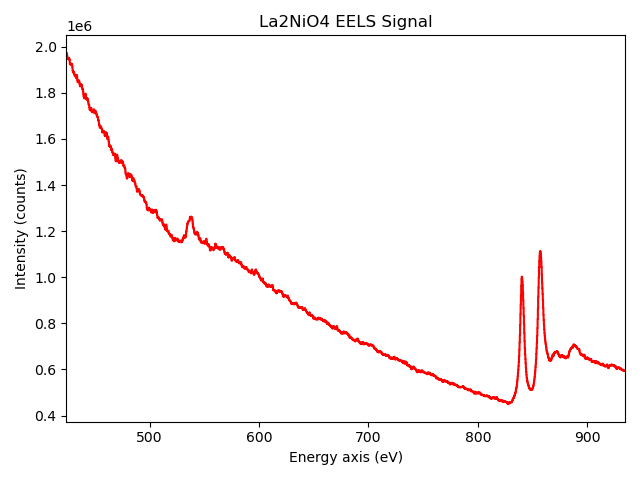

In [9]:
s.plot()

## Axes types / Convert to energy scale

*(Required versions: hyperspy>=1.7.0 and lumispy>=0.2.0)*

HyperSpy has different types of axes:
- The standard `UniformDataAxis` is defined through an `offset` and a `scale` (delta between pixels)
- A `FunctionalDataAxis` is defined through a `UniformDataAxis` and a `function` to convert the values
- A more general `DataAxis` is defined through an `axis` vector/array

The *wavelength* scale of our sample object is a `UniformDataAxis`:

In [12]:
cl1.axes_manager

Navigation axis name,size,index,offset,scale,units
x,40,5,4779.21971086405,61.27204757518014,nm
y,30,3,3798.8669496611683,61.27204757518014,nm
Signal axis name,size,,offset,scale,units
Wavelength,1015,,229.1328125,0.533203125,$nm$


*LumiSpy* provides easy conversions of the signal axis to the **energy scale**:

It can either replace the axis in the existing object (default) or create a copy of the signal object with the new axis (`inplace=False`):

In [13]:
cl1_eV = cl1.to_eV(inplace=False)

The signal axis is now a *non-uniform axis*:

In [14]:
cl1_eV.axes_manager

Navigation axis name,size,index,offset,scale,units
x,40,0,4779.21971086405,61.27204757518014,nm
y,30,0,3798.8669496611683,61.27204757518014,nm
Signal axis name,size,,offset,scale,units
Energy,1015,,non-uniform axis,non-uniform axis,eV


This axis is defined through an axis vector:

In [15]:
cl1_eV.axes_manager[-1].axis

array([1.61015793, 1.61127398, 1.61239157, ..., 5.38429428, 5.3967936 ,
       5.40935107])

To explore the data in the energy domain, we again plot the signal:

In [16]:
cl1_eV.plot()

### Jacobian transformation

To preserve the integrated intensity per spectral window, a *Jacobian* transformation has to be applied to the signal intensity:

As we require $I(E)dE = I(\lambda)d\lambda$, the scale transformation $E=hc/\lambda$ implies

$$I(E) = I(\lambda)\frac{d\lambda}{dE} = I(\lambda)\frac{d}{dE}
\frac{h c}{E} = - I(\lambda) \frac{h c}{E^2}$$

(where the minus sign just reflects the different directions of integration in the wavelength and energy domains)

This transformation is the default in LumiSpy, but can be deactivated by setting `jacobian=False`.

To visualize the effect of the *Jacobian transformation*, we can plot a signal with constant intensity before and after the transformation:

In [17]:
# Create a model signal with linear intensity
axis = {'offset': 300, 'scale': 4, 'units': 'nm', 'size': 101, 'name': 'Wavelength'}
s = hs.signals.Signal1D(np.ones(101), axes=[axis])
s.set_signal_type("Luminescence")
s2 = s.to_eV(inplace=False)

In [18]:
# Some additional arrays to help with visualizing the spectral bins during plotting
x = np.arange(9)*50+300
x2 = lum.nm2eV(x)
y2 = hs.signals.Signal1D(np.ones(9), axes=[{'offset': 300, 'scale': 50, 'size': 9,}])
y2.set_signal_type("Luminescence")
y2.to_eV()

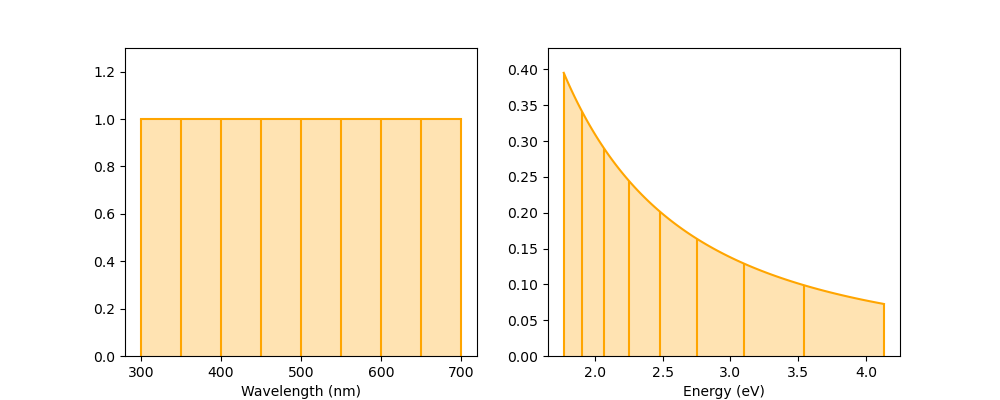

In [19]:
# Plot comparative figures
fig1 = plt.figure(figsize=(10,4))
ax0 = plt.subplot(121)
plt.ylim(0,1.3)
plt.xlabel('Wavelength (nm)')
ax0.plot(s.axes_manager[0].axis,s.data,color='orange')
ax0.vlines(x,0,1,color='orange')
ax0.fill_between(s.axes_manager[0].axis,0,s.data, facecolor='orange', alpha=0.3)
ax1 = plt.subplot(122)
plt.ylim(0,0.43)
plt.xlabel('Energy (eV)')
ax1.plot(s2.axes_manager[0].axis,s2.data,color='orange')
ax1.vlines(x2,0,y2.data[::-1],color='orange')
ax1.fill_between(s2.axes_manager[0].axis,0,s2.data, facecolor='orange', alpha=0.3)

## Model fitting

We will introduce some extended fitting functionality using our sample dataset `cl1`, for more details see the `Fitting_tutorial` in the [HyperSpy demos repository](https://github.com/hyperspy/hyperspy-demos).

Note again that HyperSpy has a range of [built-in functions](https://hyperspy.org/hyperspy-doc/current/user_guide/model.html#pre-defined-model-components) covering most needs that can be added as components to a model. However, it also has an intuitive mechanism to [define custom functions](https://hyperspy.org/hyperspy-doc/current/user_guide/model.html#define-components-from-a-mathematical-expression).

First, we need to **initialize the model**:

In [20]:
m = cl1_eV.create_model()

**Check the components** of the model:

In [21]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------

**Create some components** and **add them to the model**.

We will use a constant `Offset` and a Gaussian (defined through height and FWHM, hence `GaussianHF`):

In [22]:
bkg = hs.model.components1D.Offset()
g1 = hs.model.components1D.GaussianHF()
m.extend([g1, bkg])
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |          GaussianHF |          GaussianHF |          GaussianHF
   1 |              Offset |              Offset |              Offset

To see the parameters of our components and their default values, we can **print all parameter values**:

In [23]:
m.print_current_values()

Parameter Name,Free,Value,Std,Min,Max,Linear
centre,True,0,,,,False
fwhm,True,1,,0,,False
height,True,1,,0,,True
Parameter Name,Free,Value,Std,Min,Max,Linear
offset,True,0,,,,True


Lets set some **sensible starting values** for our components, for a position in the map where we know that there should be signal (as it is not the case everywhere for our sample dataset):

*Note that we could also use the estimate parameters function of the `GaussianHF` component (commented out line). However, this approach does not work as well as using manual starting values for this rather noisy dataset where many pixels do not contain spectra, unless additional boundaries are set to the parameters below.*

In [56]:
# g1.estimate_parameters(cl1_eV,2.3,2.5)
cl1_eV.axes_manager.indices = (7,7)
g1.centre.value = 2.4        # Gaussian centre
g1.fwhm.value = 0.1      # Gaussian width
g1.height.value = 5      # Gaussian height
bkg.offset.value = 0.1   # background offset

We can also **set boundaries** (`bmin` and `bmax`) for some of the parameters:

In [57]:
g1.centre.bmax = g1.centre.value + 0.2
g1.centre.bmin = g1.centre.value - 0.2
g1.fwhm.bmin = 0.01

We can now **fit the model at the chosen position**, copy the result as starting value to all positions, and **plot** the result:

In [58]:
m.fit(bounded=True)
m.assign_current_values_to_all()
m.plot()

Again, we can also **print the updated parameters**:

In [59]:
m.print_current_values()

Parameter Name,Free,Value,Std,Min,Max,Linear
centre,True,2.40778,0.000732481,2.2,2.6,False
fwhm,True,0.1101,0.00175439,0.01,,False
height,True,2.9272,0.0399311,0,,True
Parameter Name,Free,Value,Std,Min,Max,Linear
offset,True,-0.00360079,0.00617786,,,True


The model now has the result from our chosen pixel everywhere. Using this as optimized starting paramters, we can now **fit all pixels**. When plotting, we activate additional plotting of the individual components:

In [60]:
m.multifit(bounded=True, show_progressbar=True)
m.plot(plot_components=True)

  0%|          | 0/1200 [00:00<?, ?it/s]

To plot maps of the parameters of the Gaussian, we create signal objects from these datasets. We use the `cmap` parameter to set different color maps for the maps:

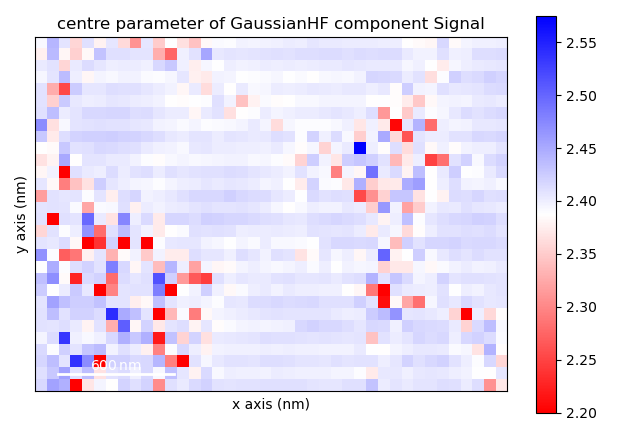

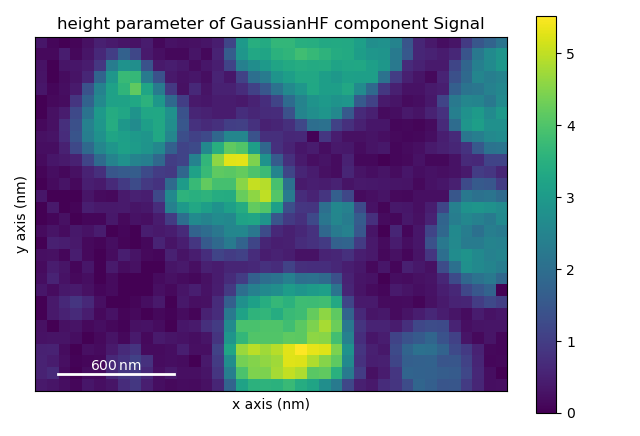

In [61]:
m_centre = g1.centre.as_signal()
m_centre.plot(cmap='bwr_r', centre_colormap=False) # Otherwise, it would be centred around `0` and we would see little difference between pixels
m_intensity = g1.height.as_signal()
m_intensity.plot(cmap='viridis')

### Particle segmentation

We can use the fit model as basis to do a particle segmentation by **creating a mask** for all pixels, where the intensity is below the mean value:

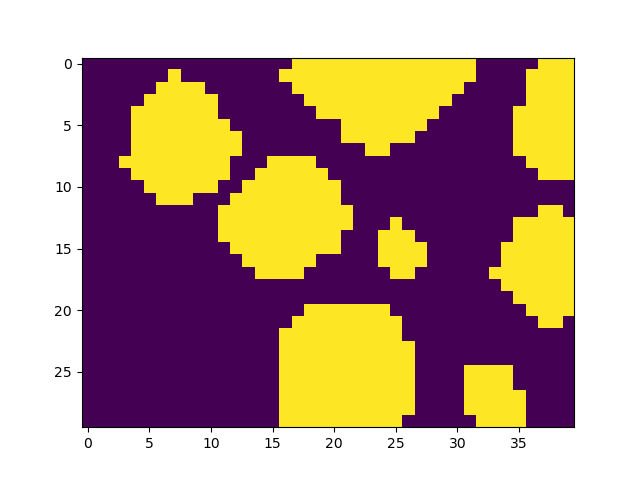

In [67]:
mask_treshold = m_intensity.data.mean()
mask = m_intensity.data > mask_treshold #Returns a boolean matrix mask
plt.figure()
plt.imshow(mask)

We can now plot the previous graph of the centre-parametre, after applying the mask:

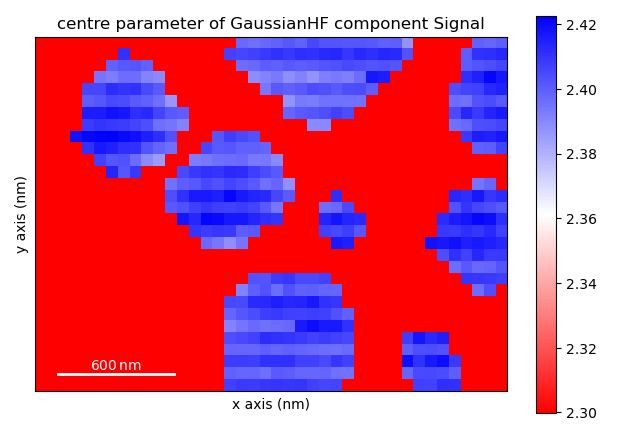

In [68]:
(m_centre * mask).plot(cmap='bwr_r', vmin=2.3, centre_colormap=False) 

## Extracting a line profile using a ROI

Interactively extract a line profile (with a certain width) from the intensity map obtained from the fit using `roi.Line2DROI`. Use `plot.plot_spectra` to plot several line profiles on the same figure. Save a profile data as ``msa`` file.

In [69]:
m_intensity

<Signal2D, title: height parameter of GaussianHF component, dimensions: (|40, 30)>

Intialize Line-ROI from position (4896, 3894) to position (6250, 4901) of width 10 in calibrated axes units (in the current example equal to the image pixels):

In [70]:
line_roi = hs.roi.Line2DROI(4896, 3894, 6250, 4901, 10)

Extract data along the ROI as new signal by “slicing” the signal and plot the profile:

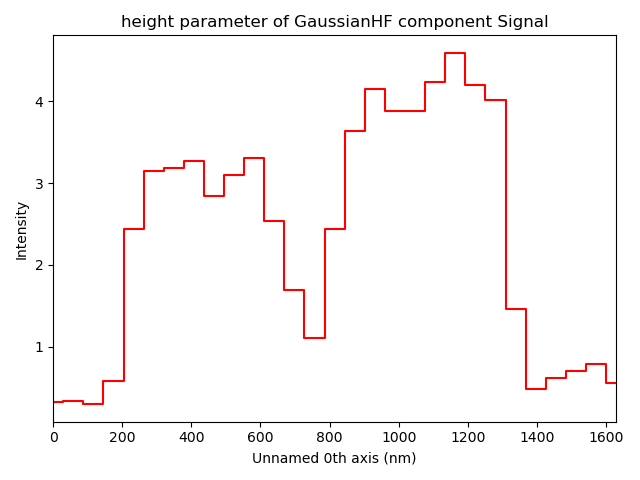

In [71]:
profile = line_roi(m_intensity)
profile.plot()

Slicing of the signal is not interactive. If you want to modify the line along which the profile is extracted, you can plot the image and display the ROI interactively (creates a new signal object). You can even display the same ROI on a second image to make sure that a profile is well placed on both images.

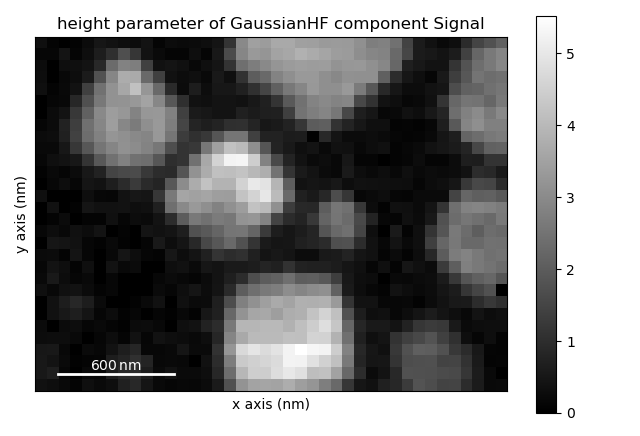

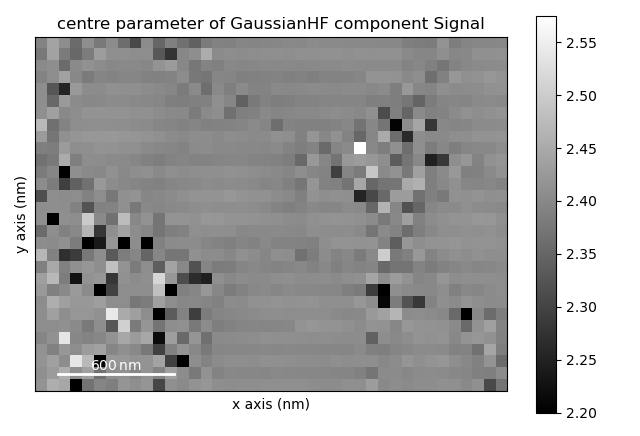

In [72]:
m_intensity.plot()
profile1 = line_roi.interactive(m_intensity, color='green')
m_centre.plot()
profile2 = line_roi.interactive(m_centre, color='green')

You can then drag and drop the ends of the ROI to adjust the placement.

If you want to later update the ROI initialization with the modified parameters, you can print these:

In [73]:
print(tuple(line_roi))

(4963.03585358959, 3860.1389972363486, 6127.204757518013, 4901.763806014411, 183.81614272554043)


You can now directly access the data of the profile objects, e.g. to plot both profiles in a single plot (though this is of limited value here, as the centre and intensity have quite different scales):

<Axes: xlabel='<undefined> (nm)', ylabel='Intensity'>

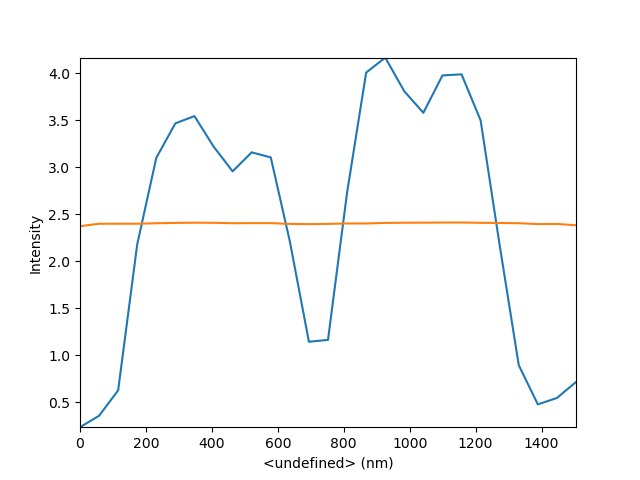

In [74]:
hs.plot.plot_spectra([profile1, profile2])

Since the profile is a signal object, you can use any other functionality provided by hyperspy, e.g. to save a profile as `.msa` text file:

In [75]:
profile1.save('extracted-line-profile.msa', format='XY', overwrite=True)

## Using the map function

To perform an operation on the data at each coordinate, HyperSpy provides the `map()` function.

As a simple example, we will apply `np.max` to get the maximum intensity from each spectrum. However, the  [`map` function](https://hyperspy.org/hyperspy-doc/current/user_guide/signal.html#iterating-external-functions-with-the-map-method) can be used to apply any functions defined for individual spectra on a complete spectral image, even passing argument.

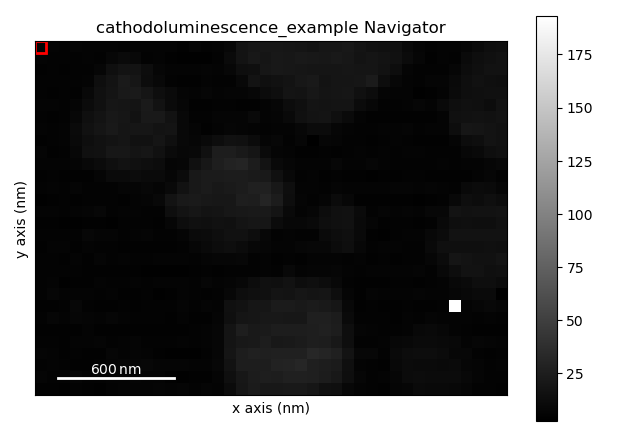

In [102]:
cl1max = cl1.map(np.max, inplace=False)
cl1max.plot()

Obviously, our dataset contains a cosmic spike that we can easily remove:

In [104]:
cl1.spikes_removal_tool(interactive=False)

WARNING | Hyperspy | Estimated number of bins using `bins='fd'` is too large (5275). Capping the number of bins at `max_num_bins=1000`. Consider using an alternative method for calculating the bins such as `bins='scott'`, or increasing the value of the `max_num_bins` keyword argument. (hyperspy.misc.hist_tools:97)


However, basic mathematic functions such as `max` are directly implemented in *HyperSpy* and we can get the same result without using `map`:

In [108]:
cl1max = cl1.max(axis=-1)
cl1max

<BaseSignal, title: cathodoluminescence_example, dimensions: (40, 30|)>

As the resulting signal has navigation, but no signal dimensions, we have to transpose it if we want to change the colormap, as the navigator plot does not support different colormaps:

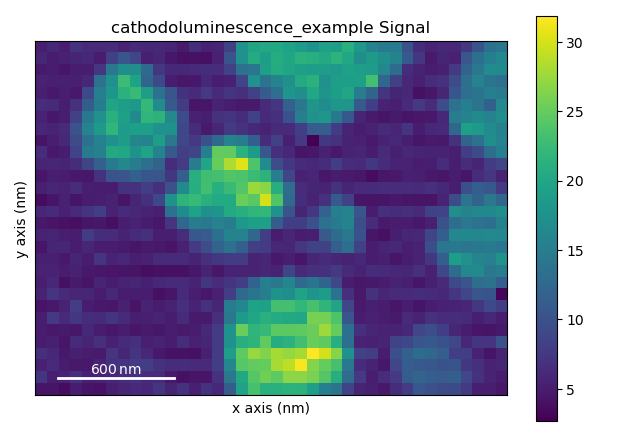

In [109]:
cl1max.T.plot(cmap='viridis')

## Advanced fitting example

Finally, to showcase the power of fitting with a programming language, lets fit the more complicated dataset `cl3`:

1. Fit a spectrum with a skew normal component on a broad Gaussian as background.

2. Then add a variable number of sharp Gaussians depending on the number of peaks found by the peak finder routine.

*The presented dataset is a CL map of luminescent centers in h-BN on SiO$_2$, similar as discussed in Hernández-Mínguez et al., [Phys. Rev. Appl. 10, 2331](https://doi.org/10.1103/PhysRevApplied.10.044031) (2018). The analysis is simplified for instructive purposes.*

*For reasons of calculation time, we run the fit on a single spectrum, but it could of course be looped across a complete spectral map - even with a variable number of peaks per spectrum.*

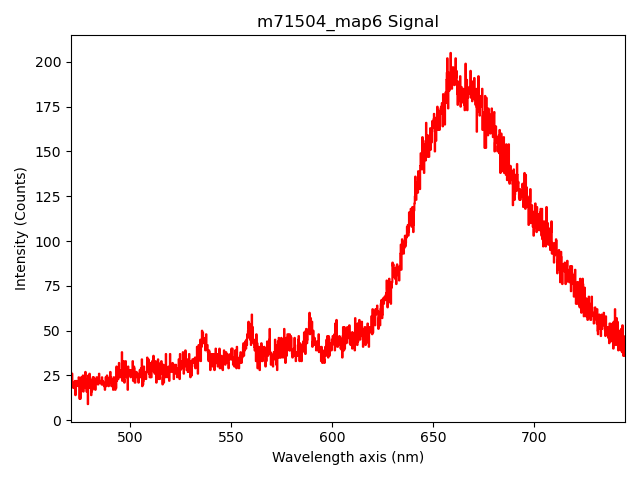

In [110]:
cl3 = cl3.inav[10,8]
m = cl3.create_model()
g1 = hs.model.components1D.SkewNormal()
g2 = hs.model.components1D.GaussianHF()
m.extend((g1,g2))
g1.x0.value=655
g1.scale.value=50
g1.shape.value=2
g1.A.value=220
g1.x0.bmin=635
g1.x0.bmax=675
g1.x0.bounded=True
g2.centre.value=580
g2.fwhm.value=180
g2.height.value=20
m.fit()
m.plot()

In [111]:
def getPeaks(S2):
    S2=S2.rebin(new_shape=[334])
    S2.smooth_savitzky_golay(window_length=15,polynomial_order=2)
    peaks = S2.find_peaks1D_ohaver(amp_thresh=0.2*np.max(S2.data),maxpeakn=10)[0]
    return peaks

[########################################] | 100% Completed | 104.07 ms


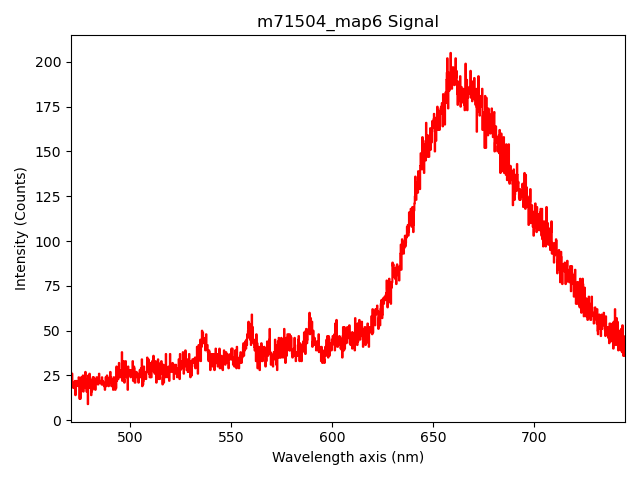

In [112]:
ng=10
S2 = cl3.deepcopy()
g = list()
for i in np.arange(ng):
    g.append(hs.model.components1D.GaussianHF())
m.extend(g)
for i in np.arange(ng):
    g[i].active_is_multidimensional = True
# The following code would need to be in a loop to run for a whole spectral image
# m.axes_manager.indices = cl3.axes_manager.indices
peaks = getPeaks(S2.inav[cl3.axes_manager.indices])
for i in np.arange(np.size(peaks)):
    g[i].centre.value=peaks['position'][i]
    g[i].centre.bmin=peaks['position'][i]-3
    g[i].centre.bmax=peaks['position'][i]+3
    g[i].centre.bounded=True
    g[i].fwhm.value=5
    g[i].fwhm.bmax=10
    g[i].fwhm.bmin=1
    g[i].fwhm.bounded=True
    g[i].height.value=20
    g[i].height.bmin=1
    g[i].height.bounded=True
if np.size(peaks)<ng:
    for i in np.arange(np.size(peaks),ng):
        g[i].active = False
m.fit(bounded=True)
m.plot()

## Now try with your own data!
